## Authors:
#### Daniel Stöckein (5018039), Alexander Triol (5018451)

In [161]:
import torch
import pandas as pd
import numpy as np
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms
from matplotlib import pyplot as plt
%matplotlib inline

## 1. Load Data & Data understanding
- get an understanding of the data

In [162]:
mnist_train = datasets.FashionMNIST("..\datasets", train=True, download=True, transform=transforms.ToTensor())
mnist_test = datasets.FashionMNIST("..\datasets", train=False, download=True, transform=transforms.ToTensor())

In [163]:
print(len(mnist_train), len(mnist_test))

60000 10000


In [164]:
print(mnist_train[1][0].shape)

torch.Size([1, 28, 28])


### 1.1 Plotting some images

<Figure size 432x288 with 0 Axes>

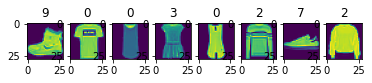

In [165]:
plt.figure()
f, axarr = plt.subplots(1,8)
for i in range(8):
    image, label = mnist_train[i]
    axarr[i].imshow(image[0])
    axarr[i].set_title(label)

### 1.2 Dataset description
- training set: 60.000 images
- test set: 10.000 images
- number of channels: 1 (greyscale)
- height: 28px
- width: 28px
- features: 28x28px = 784
- outputs: 10 categories

https://github.com/zalandoresearch/fashion-mnist

## 2. Preparing DataLoaders to iterate over batches

In [166]:
def dloaders(batch_size):
    train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

## 3. Model definition
$$\mathbf{\hat{o}} = \mathbf{x}^T \mathbf{W} + \mathbf{b}$$

### 3.1. initialize model parameters
init weights in ``nn.Sequential``: https://stackoverflow.com/questions/49433936/how-to-initialize-weights-in-pytorch

In [167]:
def init_weights(m):
    if isinstance(m, nn.Linear): # is model instance of nn.Linear?
        nn.init.normal_(m.weight, std=0.01) # initialize weights with normal distribution
        m.bias.data.fill_(0.01)

### 3.2. initialize model
`torch.nn.Sequential(*args)` A sequential container. Modules will be added to it in the order they are passed in the constructor. Alternatively, an OrderedDict of modules can be passed in. The forward() method of Sequential accepts any input and forwards it to the first module it contains. It then “chains” outputs to inputs sequentially for each subsequent module, finally returning the output of the last module. https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html

`torch.nn.Flatten(start_dim=1, end_dim=- 1)` Flattening a tensor means to remove all of the dimensions except for one. Flattens a contiguous range of dims into a tensor. For use with `Sequential`. https://pytorch.org/docs/stable/generated/torch.nn.Flatten.html

<img src="flatten.png" width="400">

`torch.nn.Linear(in_features, out_features, bias=True, device=None, dtype=None)` Applies a linear transformation to the incoming data. https://pytorch.org/docs/stable/generated/torch.nn.Linear.html

In [168]:
def init_model(in_features, out_features):
    model = nn.Sequential(nn.Flatten(), nn.Linear(in_features, out_features))
    model.apply(init_weights)
    return model

## 4. Loss function (Cross Entropy Loss)
`torch.nn.CrossEntropyLoss(weight=None, size_average=None, ignore_index=- 100, reduce=None, reduction='mean',...)`

## 5. Optimization (SGD)
`torch.optim.SGD(params, lr=<required parameter>, momentum=0, dampening=0, weight_decay=0, nesterov=False)`

## 6. Training procedure

In [169]:
train_losses, test_losses = list(), list()
train_accuracies, test_accuracies = list(), list()
# these lists are just for plotting
plt_train_losses, plt_test_losses = list(), list()
plt_train_accuracies, plt_test_accuracies = list(), list() 

def fit(model, train_loader, epochs, learning_rate, loss_func=nn.CrossEntropyLoss(), opt_func=torch.optim.SGD):
    
    loss = loss_func # computes softmax and then the cross entropy
    optimizer = opt_func(model.parameters(), learning_rate) # objective function
    
    for epoch in range(epochs):
        
        
        # --Training Phase--
        
        for i, (x_batch, y_batch) in enumerate(train_loader):

            # 1. forward
            y_hat = model(x_batch) # logits

            # 2. compute objective function (softmax, cross entropy)
            l = loss(y_hat, y_batch)

            # 3. cleaning gradients
            optimizer.zero_grad() # params.grad_zero_()

            # 4. accumulate partial derivatives
            l.backward() #params.grad.add_(dJ/dparams)

            # 5. step in the opposite direction of the gradient
            optimizer.step() # with torch.no_grad(): params = params - lr * params.grad
            
            # metrics
            train_losses.append(l.item())
            acc = accuracy(y_hat, y_batch)
            train_accuracies.append(acc)
        
        # just for plotting
        plt_train_accuracies.append(torch.tensor(train_accuracies).mean())
        plt_train_losses.append(torch.tensor(train_losses).mean())
        
        print(f'Epoch {epoch + 1}', end=', ') 
        print(f'training loss = {torch.tensor(train_losses).mean():.2f}', end=', ')
        print(f'training accuracy = {torch.tensor(train_accuracies).mean():.2f}')
        
        
        # --Validation Phase--
        
        for i, (x_batch, y_batch) in enumerate(test_loader):
            
            with torch.no_grad():
                y_hat = model(x_batch)
            
            l = loss(y_hat, y_batch)
            
            test_losses.append(l.item())
            acc = accuracy(y_hat, y_batch)
            test_accuracies.append(acc)
        
        # just for plotting
        plt_test_accuracies.append(torch.tensor(test_accuracies).mean())
        plt_test_losses.append(torch.tensor(test_losses).mean())
        
        print(f'Epoch {epoch + 1}', end=', ') 
        print(f'test loss = {torch.tensor(test_losses).mean():.2f}', end=', ')
        print(f'test accuracy = {torch.tensor(test_accuracies).mean():.2f}')

## 7. Accuracy
Correct predicted samples / total
$$ \frac{\hat{\mathbf{y}}==y}{\mathbf{n}} $$

In [170]:
def accuracy(y_hat, y):
    _, predictions = torch.max(y_hat, dim=1) # single class with highest probability. simply retain indices
    correct = (predictions == y).float()
    accuracy = correct.sum() / len(predictions) # same as .mean()
    accuracy = torch.round(accuracy * 100)
    return accuracy

Method to compare actual labels with given labels of test set. Simply prints the amount of correct & wrong classified

In [195]:
def predict(model, test_loader):
    wrong = 0
    correct = 0
    for X, y in test_loader:
        trues = y
        preds = model(X).argmax(axis=1)
        for true, pred in zip(trues, preds):
            if true != pred:
                wrong += 1
            else:
                correct += 1
    print(f'Correct classified: {correct}')
    print(f'Wrong classified: {wrong}')
    print(f'Total Accuracy: {correct / (correct + wrong) * 100}')

## 8. Playground

### 1. Attempt

In [198]:
# hyperparameters
batch_size = 50
epochs = 10
learning_rate = 0.01

In [199]:
train_loader, test_loader = dloaders(batch_size=batch_size) # data iters
model = init_model(in_features=28*28, out_features=10) # model initialization
fit(model, train_loader, epochs, learning_rate) # training

Epoch 1, training loss = 0.52, training accuracy = 82.92
Epoch 1, test loss = 0.53, test accuracy = 82.00
Epoch 2, training loss = 0.53, training accuracy = 82.79
Epoch 2, test loss = 0.53, test accuracy = 81.90
Epoch 3, training loss = 0.53, training accuracy = 82.73
Epoch 3, test loss = 0.53, test accuracy = 81.84
Epoch 4, training loss = 0.53, training accuracy = 82.71
Epoch 4, test loss = 0.54, test accuracy = 81.81
Epoch 5, training loss = 0.53, training accuracy = 82.71
Epoch 5, test loss = 0.54, test accuracy = 81.81
Epoch 6, training loss = 0.53, training accuracy = 82.72
Epoch 6, test loss = 0.54, test accuracy = 81.81
Epoch 7, training loss = 0.53, training accuracy = 82.75
Epoch 7, test loss = 0.54, test accuracy = 81.83
Epoch 8, training loss = 0.53, training accuracy = 82.78
Epoch 8, test loss = 0.53, test accuracy = 81.84
Epoch 9, training loss = 0.52, training accuracy = 82.81
Epoch 9, test loss = 0.53, test accuracy = 81.87
Epoch 10, training loss = 0.52, training accur

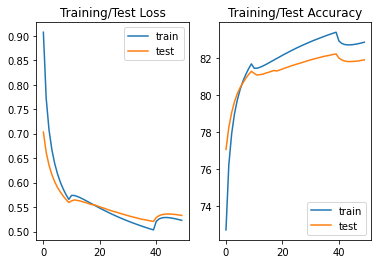

In [200]:
# Losses
plt.subplot(1, 2, 1)
plt.plot(plt_train_losses, label='train')
plt.plot(plt_test_losses, label='test')
plt.legend()
plt.title('Training/Test Loss')

# Accuracies
plt.subplot(1, 2, 2)
plt.plot(plt_train_accuracies, label='train')
plt.plot(plt_test_accuracies, label='test')
plt.legend()
plt.title('Training/Test Accuracy')

plt.show()

In [201]:
predict(model, test_loader)

Correct classified: 8270
Wrong classified: 1730
Total Accuracy: 82.69999999999999


### Summary 1. Attempt
Some text

## 2. Attempt

In [202]:
# hyperparameters
batch_size = 256
epochs = 30
learning_rate = 0.2

In [203]:
train_loader, test_loader = dloaders(batch_size=batch_size) # data iters
model = init_model(in_features=28*28, out_features=10) # model initialization
fit(model, train_loader, epochs, learning_rate) # training

Epoch 1, training loss = 0.52, training accuracy = 82.80
Epoch 1, test loss = 0.53, test accuracy = 81.88
Epoch 2, training loss = 0.52, training accuracy = 82.79
Epoch 2, test loss = 0.53, test accuracy = 81.87
Epoch 3, training loss = 0.52, training accuracy = 82.79
Epoch 3, test loss = 0.54, test accuracy = 81.83
Epoch 4, training loss = 0.52, training accuracy = 82.79
Epoch 4, test loss = 0.54, test accuracy = 81.83
Epoch 5, training loss = 0.52, training accuracy = 82.79
Epoch 5, test loss = 0.54, test accuracy = 81.83
Epoch 6, training loss = 0.52, training accuracy = 82.80
Epoch 6, test loss = 0.54, test accuracy = 81.83
Epoch 7, training loss = 0.52, training accuracy = 82.81
Epoch 7, test loss = 0.54, test accuracy = 81.85
Epoch 8, training loss = 0.52, training accuracy = 82.82
Epoch 8, test loss = 0.54, test accuracy = 81.84
Epoch 9, training loss = 0.52, training accuracy = 82.83
Epoch 9, test loss = 0.54, test accuracy = 81.84
Epoch 10, training loss = 0.52, training accur

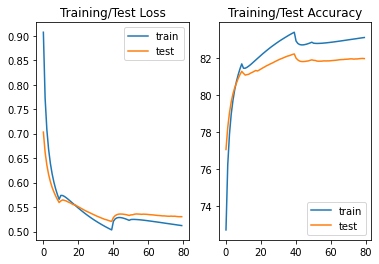

In [204]:
# Losses
plt.subplot(1, 2, 1)
plt.plot(plt_train_losses, label='train')
plt.plot(plt_test_losses, label='test')
plt.legend()
plt.title('Training/Test Loss')

# Accuracies
plt.subplot(1, 2, 2)
plt.plot(plt_train_accuracies, label='train')
plt.plot(plt_test_accuracies, label='test')
plt.legend()
plt.title('Training/Test Accuracy')

plt.show()

In [205]:
predict(model, test_loader)

Correct classified: 8044
Wrong classified: 1956
Total Accuracy: 80.44


### Summary 2. Attempt
Some Text

## 3. Attempt

In [206]:
# hyperparameters
batch_size = 100
epochs = 15
learning_rate = 0.001

In [207]:
train_loader, test_loader = dloaders(batch_size=batch_size) # data iters
model = init_model(in_features=28*28, out_features=10) # model initialization
fit(model, train_loader, epochs, learning_rate) # training

Epoch 1, training loss = 0.53, training accuracy = 82.75
Epoch 1, test loss = 0.54, test accuracy = 81.75
Epoch 2, training loss = 0.54, training accuracy = 82.53
Epoch 2, test loss = 0.55, test accuracy = 81.55
Epoch 3, training loss = 0.55, training accuracy = 82.34
Epoch 3, test loss = 0.56, test accuracy = 81.36
Epoch 4, training loss = 0.55, training accuracy = 82.17
Epoch 4, test loss = 0.57, test accuracy = 81.20
Epoch 5, training loss = 0.56, training accuracy = 82.01
Epoch 5, test loss = 0.57, test accuracy = 81.06
Epoch 6, training loss = 0.56, training accuracy = 81.88
Epoch 6, test loss = 0.57, test accuracy = 80.93
Epoch 7, training loss = 0.57, training accuracy = 81.77
Epoch 7, test loss = 0.58, test accuracy = 80.82
Epoch 8, training loss = 0.57, training accuracy = 81.67
Epoch 8, test loss = 0.58, test accuracy = 80.72
Epoch 9, training loss = 0.58, training accuracy = 81.58
Epoch 9, test loss = 0.58, test accuracy = 80.63
Epoch 10, training loss = 0.58, training accur

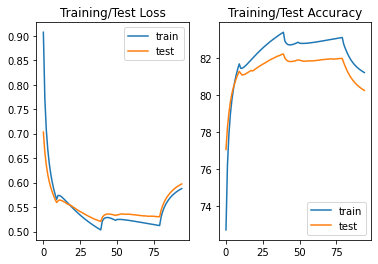

In [208]:
# Losses
plt.subplot(1, 2, 1)
plt.plot(plt_train_losses, label='train')
plt.plot(plt_test_losses, label='test')
plt.legend()
plt.title('Training/Test Loss')

# Accuracies
plt.subplot(1, 2, 2)
plt.plot(plt_train_accuracies, label='train')
plt.plot(plt_test_accuracies, label='test')
plt.legend()
plt.title('Training/Test Accuracy')

plt.show()

In [209]:
predict(model, test_loader)

Correct classified: 7569
Wrong classified: 2431
Total Accuracy: 75.69
